In [1]:
import pandas as pd
import numpy as np

# FOREST HEALTH UK #

### Uploading the data set

In [2]:

df = pd.read_csv('/Users/sandra/Desktop/Capstone/EDA_forest.csv')
df.head()

,year,species,plot_type,assessment_type,plot_number,subplot,tree_number,local_crown_density,diameter_mm,height_cm,...,nitrous_oxide,sulphur_dioxide,volatile_organic_compounds,particulate_matter_10,particulate_matter_25,ann_rainfall,ann_temperature,current_brwoning_needles,age,mean_col
0,1995,Oak,OK,I,1,N,1,15.0,875.0,0.0,...,86.45724,38.979309,93.290781,41.82557,34.350562,751.8,10.07,NaN,175,17.298236
1,1995,Oak,OK,I,1,N,2,25.0,517.0,0.0,...,86.45724,38.979309,93.290781,41.82557,34.350562,751.8,10.07,NaN,175,17.298236
2,1995,Oak,OK,I,1,N,3,15.0,673.0,0.0,...,86.45724,38.979309,93.290781,41.82557,34.350562,751.8,10.07,NaN,175,17.298236
3,1995,Oak,OK,I,1,N,4,10.0,621.0,0.0,...,86.45724,38.979309,93.290781,41.82557,34.350562,751.8,10.07,NaN,175,17.298236
4,1995,Oak,OK,I,1,N,5,25.0,1020.0,0.0,...,86.45724,38.979309,93.290781,41.82557,34.350562,751.8,10.07,NaN,175,17.298236


In [3]:
df.shape

(46925, 65)

In [4]:
df.local_crown_density.unique()

array([15., 25., 10., 30., 55., 40., 60., 45., 20.,  5., 50., 75., 70.,
       35.,  0., 65., 80., 90., 85., 99., 95.])

### Creating binary target variable crown density class

In [5]:
crown_mean = np.mean(df['mean_col'])
crown_mean

21.225572722425014

In [6]:
df['Crown_density_class'] = [1 if i > crown_mean else 0 for i in df.local_crown_density]
df.head()

,year,species,plot_type,assessment_type,plot_number,subplot,tree_number,local_crown_density,diameter_mm,height_cm,...,sulphur_dioxide,volatile_organic_compounds,particulate_matter_10,particulate_matter_25,ann_rainfall,ann_temperature,current_brwoning_needles,age,mean_col,Crown_density_class
0,1995,Oak,OK,I,1,N,1,15.0,875.0,0.0,...,38.979309,93.290781,41.82557,34.350562,751.8,10.07,NaN,175,17.298236,0
1,1995,Oak,OK,I,1,N,2,25.0,517.0,0.0,...,38.979309,93.290781,41.82557,34.350562,751.8,10.07,NaN,175,17.298236,1
2,1995,Oak,OK,I,1,N,3,15.0,673.0,0.0,...,38.979309,93.290781,41.82557,34.350562,751.8,10.07,NaN,175,17.298236,0
3,1995,Oak,OK,I,1,N,4,10.0,621.0,0.0,...,38.979309,93.290781,41.82557,34.350562,751.8,10.07,NaN,175,17.298236,0
4,1995,Oak,OK,I,1,N,5,25.0,1020.0,0.0,...,38.979309,93.290781,41.82557,34.350562,751.8,10.07,NaN,175,17.298236,1


In [7]:
from scipy import stats
import statsmodels.api as sm
import pmdarima as pmd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# MODELING

### Baseline

In [9]:
df_copy = df.copy()

In [10]:
#baseline accuracy
df.Crown_density_class.value_counts(normalize=True).max()

0.6209483217900905

In [11]:
#classification target
y = df_copy.pop('Crown_density_class')

In [12]:
y.shape

(46925,)

In [13]:
#classification predictors

### Creating first set of predictors

In [14]:
X = df_copy[[ 'diameter_mm', 'height_cm', 'shoot_death_branch',
        'defoliation_type',
       'overall_discolouration', 
        'damage_butt_stem', 'damage_game',
       'damage_insect', 'damage_fungal', 'damage_abiotic', 'damage_man',
       'damage_fire', 'damage_other', 'ammonia', 'nitrous_oxide', 'sulphur_dioxide', 'volatile_organic_compounds', 'particulate_matter_10', 'particulate_matter_25','ann_temperature',       
                       
'ann_rainfall']]

In [15]:
X = pd.get_dummies(X,columns = [
       'defoliation_type',
       'overall_discolouration', 
        'damage_butt_stem', 'damage_game',
       'damage_insect', 'damage_fungal', 'damage_abiotic', 'damage_man',
       'damage_fire', 'damage_other', 'shoot_death_branch'
       ], drop_first = True)
X.columns

Index(['diameter_mm', 'height_cm', 'ammonia', 'nitrous_oxide',
       'sulphur_dioxide', 'volatile_organic_compounds',
       'particulate_matter_10', 'particulate_matter_25', 'ann_temperature',
       'ann_rainfall', 'defoliation_type_defoliation of upper crown',
       'defoliation_type_gaps in the lateral branch system',
       'defoliation_type_large gaps in the lateral branch system',
       'defoliation_type_less than 20% loss of density',
       'defoliation_type_mechanicla_damage', 'defoliation_type_other',
       'defoliation_type_peripheral defoliation',
       'defoliation_type_spot-like defoliation',
       'overall_discolouration_11-25% of needles/leaves',
       'overall_discolouration_26-60% of needles/leaves',
       'overall_discolouration_61-99% of needles/leaves',
       'overall_discolouration_dead trees', 'damage_game_present',
       'damage_insect_common', 'damage_insect_infrequent',
       'damage_insect_none', 'damage_insect_rare', 'damage_fungal_common',
     

In [16]:
X.shape

(46925, 41)

### Creating second set of predictors

In [17]:
X2 = df_copy[[ 'diameter_mm', 'height_cm', 'shoot_death_branch',
        'defoliation_type','broadleaf_dieback_type', 'leaf_browning',                 
'leaf_yellowing',      
'broadleaf_dieback_extend_per',
       'overall_discolouration', 
        'damage_butt_stem', 'damage_game',
       'damage_insect', 'damage_fungal', 'damage_abiotic', 'damage_man',
       'damage_fire', 'damage_other', 'ammonia', 'nitrous_oxide', 'sulphur_dioxide', 'volatile_organic_compounds', 'particulate_matter_10', 'particulate_matter_25','ann_temperature',       
                       
'ann_rainfall', 'latitude','age' ]]

In [18]:
X2 = pd.get_dummies(X2,columns = [
       'defoliation_type', 'broadleaf_dieback_type', 'leaf_browning',                 
'leaf_yellowing',      
       'overall_discolouration', 
        'damage_butt_stem', 'damage_game',
       'damage_insect', 'damage_fungal', 'damage_abiotic', 'damage_man',
       'damage_fire', 'damage_other', 'shoot_death_branch'
       ], drop_first = True)
X2.columns

Index(['diameter_mm', 'height_cm', 'broadleaf_dieback_extend_per', 'ammonia',
       'nitrous_oxide', 'sulphur_dioxide', 'volatile_organic_compounds',
       'particulate_matter_10', 'particulate_matter_25', 'ann_temperature',
       'ann_rainfall', 'latitude', 'age',
       'defoliation_type_defoliation of upper crown',
       'defoliation_type_gaps in the lateral branch system',
       'defoliation_type_large gaps in the lateral branch system',
       'defoliation_type_less than 20% loss of density',
       'defoliation_type_mechanicla_damage', 'defoliation_type_other',
       'defoliation_type_peripheral defoliation',
       'defoliation_type_spot-like defoliation',
       'broadleaf_dieback_type_branches at the base of the crown',
       'broadleaf_dieback_type_middle parts of the crown',
       'broadleaf_dieback_type_none',
       'broadleaf_dieback_type_throughout the crown',
       'broadleaf_dieback_type_top and middle',
       'broadleaf_dieback_type_top of the tree only',
  

In [19]:
X2.shape

(46925, 60)

### Creating third set of predictors

In [20]:
x3 = df_copy

In [21]:
x3 = pd.get_dummies(x3, drop_first = True)
x3.columns

Index(['year', 'plot_number', 'tree_number', 'local_crown_density',
       'diameter_mm', 'height_cm', 'broadleaf_dieback_location',
       'broadleaf_dieback_extend_per', 'mechanical_damage_type_1',
       'mechanical_damage_1',
       ...
       'address_Woodditton, Ditton Green, Cambridgeshire, East of England, England, United Kingdom',
       'address_Woodlands, Honey Hill, Blean, Canterbury, Kent, South East England, England, CT2 9JW, United Kingdom',
       'address_Woodside Court, Dalbeattie, Dumfries and Galloway, Scotland, DG5 4NX, United Kingdom',
       'address_Wytham Woods, Middle Ride, Wytham, Vale of White Horse, Oxfordshire, South East England, England, OX2 8QQ, United Kingdom',
       'address_Yardley Hastings, West Northamptonshire, East Midlands, England, United Kingdom',
       'address_Ynys Hir Hide, A487, Ysgubor-y-coed, Ffwrnais / Furnace, Ceredigion, Cymru / Wales, SY20 8ND, United Kingdom',
       'address_Ystradfellte, Pontneddfechan, Powys, Cymru / Wales, SA1

### Applying the models

In [22]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


def docm(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    if labels is not None:
        cols = ['p_'+c for c in labels]
        df = pd.DataFrame(cm, index=labels, columns=cols)
    else:
        cols = ['p_'+str(i) for i in range(len(cm))]
        df = pd.DataFrame(cm, columns=cols)
    return df

### Model set 1 - X

In [24]:
#models to be used
models = [KNeighborsClassifier(),
          LogisticRegression(multi_class='ovr', max_iter=1000),
          DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=100),
          ExtraTreesClassifier(n_estimators=100)]
#setting target and predictors
#y = df.Crown_density_class
X = X
#train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,
     random_state=1)
#applying SMOTE to avoid class imbalance
oversample = SMOTE()
X_train,y_train = oversample.fit_resample(X_train, y_train)

#standarizing with standard scaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

res = []

for model in models:
    print(model)
    print()
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    print('train score:', train_score)
    test_score = model.score(X_test, y_test)
    print('test score:', test_score)
    cross_val = cross_val_score(model, X_train, y_train, cv=5)
    print('cross val score:', cross_val)
    cross_val_mean = cross_val_score(model, X_train, y_train, cv=5).mean()
    print('cross val mean score:', cross_val_mean)
    y_pred = model.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    print('accuracy score:', acc_score)
    print()
    cm = docm(y_test, y_pred)
    print(cm)
    res.append([model,train_score, test_score,cross_val, cross_val_mean, acc_score])
    print()
    print('-'*60)
    print()

KNeighborsClassifier()

train score: 0.8305382800772035
test score: 0.7071923281832712
cross val score: [0.67735363 0.66823933 0.67864036 0.82221746 0.83497748]
cross val mean score: 0.7362856530130818
accuracy score: 0.7071923281832712

    p_0   p_1
0  4510  1313
1  1435  2127

------------------------------------------------------------

LogisticRegression(max_iter=1000, multi_class='ovr')

train score: 0.7434269783401244
test score: 0.7000532765050612
cross val score: [0.65612267 0.66266352 0.65805276 0.82328973 0.83304739]
cross val mean score: 0.7266352133819429
accuracy score: 0.7000532765050612

    p_0   p_1
0  4465  1358
1  1457  2105

------------------------------------------------------------

DecisionTreeClassifier()

train score: 0.9919794123954536
test score: 0.6663825253063399
cross val score: [0.65258417 0.65236972 0.65322754 0.80066481 0.81492601]
cross val mean score: 0.7147758953463436
accuracy score: 0.6663825253063399

    p_0   p_1
0  4206  1617
1  1514  2048

-

In [25]:
X_train.shape

(46630, 41)

In [26]:
X_test.shape

(9385, 41)

In [27]:
X.shape

(46925, 41)

### Model set 2  - X2

In [28]:
models2 = [KNeighborsClassifier(),
          LogisticRegression(multi_class='ovr', max_iter=1000),
          DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=100),
          ExtraTreesClassifier(n_estimators=100)]

#target and predictors
#y = df.Crown_density_class
X2 = X2


#train test split
X2_train, X2_test, y_train, y_test = train_test_split(
    X2, y, test_size=0.2,
     random_state=1)

#applying SMOTE to avoid class imbalance
oversample = SMOTE()
X2_train,y_train = oversample.fit_resample(X2_train, y_train)

#standarizing with standard scaler
scaler = StandardScaler()
X2_train = pd.DataFrame(scaler.fit_transform(X2_train), columns=X2.columns)
X2_test = pd.DataFrame(scaler.transform(X2_test), columns=X2.columns)

res = []

for model in models2:
    print(model)
    print()
    model.fit(X2_train, y_train)
    train_score = model.score(X2_train, y_train)
    print('train score:', train_score)
    test_score = model.score(X2_test, y_test)
    print('test score:', test_score)
    cross_val = cross_val_score(model, X2_train, y_train, cv=5)
    print('cross val score:', cross_val)
    cross_val_mean = cross_val_score(model, X2_train, y_train, cv=5).mean()
    print('cross val mean score:', cross_val_mean)
    y_pred = model.predict(X2_test)
    acc_score = accuracy_score(y_test, y_pred)
    print('accuracy score:', acc_score)
    print()
    cm = docm(y_test, y_pred)
    print(cm)
    res.append([model,train_score, test_score,cross_val, cross_val_mean, acc_score])
    print()
    print('-'*60)
    print()

KNeighborsClassifier()

train score: 0.8471584816641647
test score: 0.7312733084709643
cross val score: [0.69215098 0.69032811 0.69751233 0.85277718 0.85610122]
cross val mean score: 0.7577739652584173
accuracy score: 0.7312733084709643

    p_0   p_1
0  4650  1173
1  1349  2213

------------------------------------------------------------

LogisticRegression(max_iter=1000, multi_class='ovr')

train score: 0.7735149045678748
test score: 0.731592967501332
cross val score: [0.68207163 0.69418829 0.69118593 0.85535063 0.86875402]
cross val mean score: 0.7583101007934806
accuracy score: 0.731592967501332

    p_0   p_1
0  4736  1087
1  1432  2130

------------------------------------------------------------

DecisionTreeClassifier()

train score: 0.9991850739867039
test score: 0.7224294086307939
cross val score: [0.70298091 0.7084495  0.69912074 0.83411967 0.84033884]
cross val mean score: 0.7593823718636072
accuracy score: 0.7224294086307939

    p_0   p_1
0  4490  1333
1  1272  2290

---

In [29]:
X2_train.shape

(46630, 60)

In [30]:
X2_test.shape

(9385, 60)

In [31]:
y_train.shape

(46630,)

In [32]:
y_test.shape

(9385,)

In [33]:
X2.shape

(46925, 60)

### Model set 3 - X3

In [34]:
models3 = [KNeighborsClassifier(),
          LogisticRegression(multi_class='ovr', max_iter=1000),
          DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=100),
          ExtraTreesClassifier(n_estimators=100)]

#target and predictors
#y = df.Crown_density_class
x3 = x3

#train test split
x3_train, x3_test, y_train, y_test = train_test_split(
    x3, y, test_size=0.2,
     random_state=1)

#applying SMOTE to avoid class imbalance
oversample = SMOTE()
x3_train,y_train = oversample.fit_resample(x3_train, y_train)

#standarizing with standard scaler
scaler = StandardScaler()
x3_train = pd.DataFrame(scaler.fit_transform(x3_train), columns=x3.columns)
x3_test = pd.DataFrame(scaler.transform(x3_test), columns=x3.columns)

res = []

for model in models3:
    print(model)
    print()
    model.fit(x3_train, y_train)
    train_score = model.score(x3_train, y_train)
    print('train score:', train_score)
    test_score = model.score(x3_test, y_test)
    print('test score:', test_score)
    cross_val = cross_val_score(model, x3_train, y_train, cv=5)
    print('cross val score:', cross_val)
    cross_val_mean = cross_val_score(model, x3_train, y_train, cv=5).mean()
    print('cross val mean score:', cross_val_mean)
    y_pred = model.predict(x3_test)
    acc_score = accuracy_score(y_test, y_pred)
    print('accuracy score:', acc_score)
    print()
    cm = docm(y_test, y_pred)
    print(cm)
    res.append([model,train_score, test_score,cross_val, cross_val_mean, acc_score])
    print()
    print('-'*60)
    print()

KNeighborsClassifier()

train score: 0.8044606476517263
test score: 0.6663825253063399
cross val score: [0.68142827 0.68689685 0.67402959 0.77643148 0.79380227]
cross val mean score: 0.7225176924726571
accuracy score: 0.6663825253063399

    p_0   p_1
0  3627  2196
1   935  2627

------------------------------------------------------------

LogisticRegression(max_iter=1000, multi_class='ovr')

train score: 1.0
test score: 0.9935002663825253
cross val score: [0.99388805 0.99356637 0.99356637 0.99678319 0.99753378]
cross val mean score: 0.9950675530774179
accuracy score: 0.9935002663825253

    p_0   p_1
0  5791    32
1    29  3533

------------------------------------------------------------

DecisionTreeClassifier()

train score: 1.0
test score: 1.0
cross val score: [1. 1. 1. 1. 1.]
cross val mean score: 1.0
accuracy score: 1.0

    p_0   p_1
0  5823     0
1     0  3562

------------------------------------------------------------

RandomForestClassifier()

train score: 1.0
test score:

### Applying Grid Search CV on the best performing model across 3 model sets

In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
model = LogisticRegression(multi_class='ovr', max_iter=1000)
list(model.get_params().keys())

['C',
 'class_weight',
 'dual',
 'fit_intercept',
 'intercept_scaling',
 'l1_ratio',
 'max_iter',
 'multi_class',
 'n_jobs',
 'penalty',
 'random_state',
 'solver',
 'tol',
 'verbose',
 'warm_start']

In [37]:
model = LogisticRegression(multi_class='ovr')
params = {'C': np.logspace(-4, 4, 10),
          'max_iter': [1000],
          'penalty': ['l2'],
          'fit_intercept': [True, False]}


gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  cv=5,
                  scoring='accuracy',
                  return_train_score=True)

gs.fit(X2_train, y_train)

# extract the grid search results

print('Best Parameters:')
print(gs.best_params_)
print('Best estimator C:')
print(gs.best_estimator_.C)
print('Best estimator mean cross validated training score:')
print(gs.best_score_)
print('Best estimator score on the full training set:')
print(gs.score(X2_train, y_train))
print('Best estimator score on the test set:')
print(gs.score(X2_test, y_test))
print('Best estimator coefficients:')
print(gs.best_estimator_.coef_)

/Users/sandra/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Parameters:
{'C': 166.81005372000558, 'fit_intercept': False, 'max_iter': 1000, 'penalty': 'l2'}
Best estimator C:
166.81005372000558
Best estimator mean cross validated training score:
0.7585460004289084
Best estimator score on the full training set:
0.7722067338623204
Best estimator score on the test set:
0.7323388385721896
Best estimator coefficients:
[[-4.11510645e-01 -5.30769691e-03  7.85189349e-01  1.86455091e-01
  -2.93131797e+00  2.01175996e+00  2.39609645e-01 -1.37028012e+00
   1.37504506e+00 -5.11610859e-01 -3.76667363e-01 -2.74093770e-01
   1.90039192e-01 -1.36689734e-01 -9.19437801e-03  1.72857810e-01
  -1.16125703e+00  9.66320072e-02  4.21979090e-02 -4.07405957e-01
   8.56135094e-02 -1.50820981e-01 -1.01778584e+00 -9.54241577e-01
  -1.13513999e+00 -4.97169624e-01 -5.81536164e-01 -1.39158968e-01
   1.86818557e-02 -9.46075014e-01  5.21761662e+01 -1.34037459e-01
  -5.26922681e+01 -1.80986353e-01 -4.76718925e-01 -9.73136560e-01
  -3.36226374e-01 -4.58444556e-02  9.9610093

In [38]:
pd.DataFrame(gs.cv_results_).sort_values(by=['mean_test_score', 'std_test_score'], ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_fit_intercept,param_max_iter,param_penalty,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
15,1.187500,0.115638,0.003273,0.000486,166.810054,False,1000,l2,"{'C': 166.81005372000558, 'fit_intercept': Fal...",0.674887,...,0.758546,0.090862,1,0.793213,0.791148,0.791711,0.748821,0.744773,0.773933,0.022204
17,1.655883,0.411284,0.003028,0.000042,1291.549665,False,1000,l2,"{'C': 1291.5496650148827, 'fit_intercept': Fal...",0.677032,...,0.758396,0.088955,2,0.793749,0.791524,0.791336,0.748874,0.744451,0.773987,0.022370
19,1.753418,0.447500,0.003018,0.000084,10000.0,False,1000,l2,"{'C': 10000.0, 'fit_intercept': False, 'max_it...",0.680463,...,0.758332,0.086392,3,0.794097,0.790827,0.791470,0.750536,0.745416,0.774469,0.021720
12,0.878955,0.104095,0.003243,0.000450,21.544347,True,1000,l2,"{'C': 21.54434690031882, 'fit_intercept': True...",0.681857,...,0.758074,0.084851,4,0.794044,0.790612,0.791202,0.750617,0.745952,0.774485,0.021475
16,0.396320,0.042082,0.003044,0.000140,1291.549665,True,1000,l2,"{'C': 1291.5496650148827, 'fit_intercept': Tru...",0.681964,...,0.758074,0.084759,4,0.794124,0.790639,0.791282,0.750348,0.745872,0.774453,0.021587
18,0.382851,0.040963,0.003167,0.000439,10000.0,True,1000,l2,"{'C': 10000.0, 'fit_intercept': True, 'max_ite...",0.681964,...,0.758053,0.084775,6,0.794124,0.790612,0.791202,0.750643,0.745872,0.774491,0.021505
14,0.429780,0.046358,0.003075,0.000128,166.810054,True,1000,l2,"{'C': 166.81005372000558, 'fit_intercept': Tru...",0.681857,...,0.758010,0.084812,7,0.794044,0.790666,0.791309,0.750617,0.745925,0.774512,0.021507
13,1.029304,0.171033,0.002999,0.000063,21.544347,False,1000,l2,"{'C': 21.54434690031882, 'fit_intercept': Fals...",0.673922,...,0.757967,0.091716,8,0.793186,0.791256,0.792033,0.748767,0.744719,0.773992,0.022294
10,0.816748,0.089643,0.003400,0.000544,2.782559,True,1000,l2,"{'C': 2.782559402207126, 'fit_intercept': True...",0.681964,...,0.757946,0.085002,9,0.794258,0.790130,0.791765,0.750831,0.746033,0.774603,0.021463
8,0.518179,0.035843,0.003003,0.000064,0.359381,True,1000,l2,"{'C': 0.3593813663804626, 'fit_intercept': Tru...",0.680785,...,0.757774,0.085508,10,0.794044,0.790344,0.791122,0.750429,0.745979,0.774383,0.021457


In [39]:
best_model = LogisticRegression(multi_class='ovr', max_iter=1000)
best_model.fit(X2_train, y_train)
test_score = best_model.score(X2_test, y_test)
print('test score:', test_score)

test score: 0.731592967501332


In [40]:
predictions = best_model.predict(X2_test)

### Model Evaluation

In [41]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
import scikitplot as skplt

In [42]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [43]:
df_coef = pd.DataFrame(best_model.coef_.T, index=X2_train.columns,
                       columns=['importance'])
#  values of the coefficients
df_coef.sort_values(by = 'importance', ascending = False)

,importance
sulphur_dioxide,1.748420
shoot_death_branch_n/a for beach and oak trees,1.623773
particulate_matter_25,1.163470
broadleaf_dieback_extend_per,0.858265
overall_discolouration_dead trees,0.551319
leaf_browning_scattered leaves entirely brown,0.364823
ammonia,0.201720
age,0.190928
defoliation_type_large gaps in the lateral branch system,0.180584
volatile_organic_compounds,0.179174


In [44]:
df_coef['coef_abs'] = df_coef.importance.abs()
df_coef

,importance,coef_abs
diameter_mm,-0.410517,0.410517
height_cm,-0.005579,0.005579
broadleaf_dieback_extend_per,0.858265,0.858265
ammonia,0.201720,0.201720
nitrous_oxide,-2.468559,2.468559
sulphur_dioxide,1.748420,1.748420
volatile_organic_compounds,0.179174,0.179174
particulate_matter_10,-1.305033,1.305033
particulate_matter_25,1.163470,1.163470
ann_temperature,-0.483824,0.483824


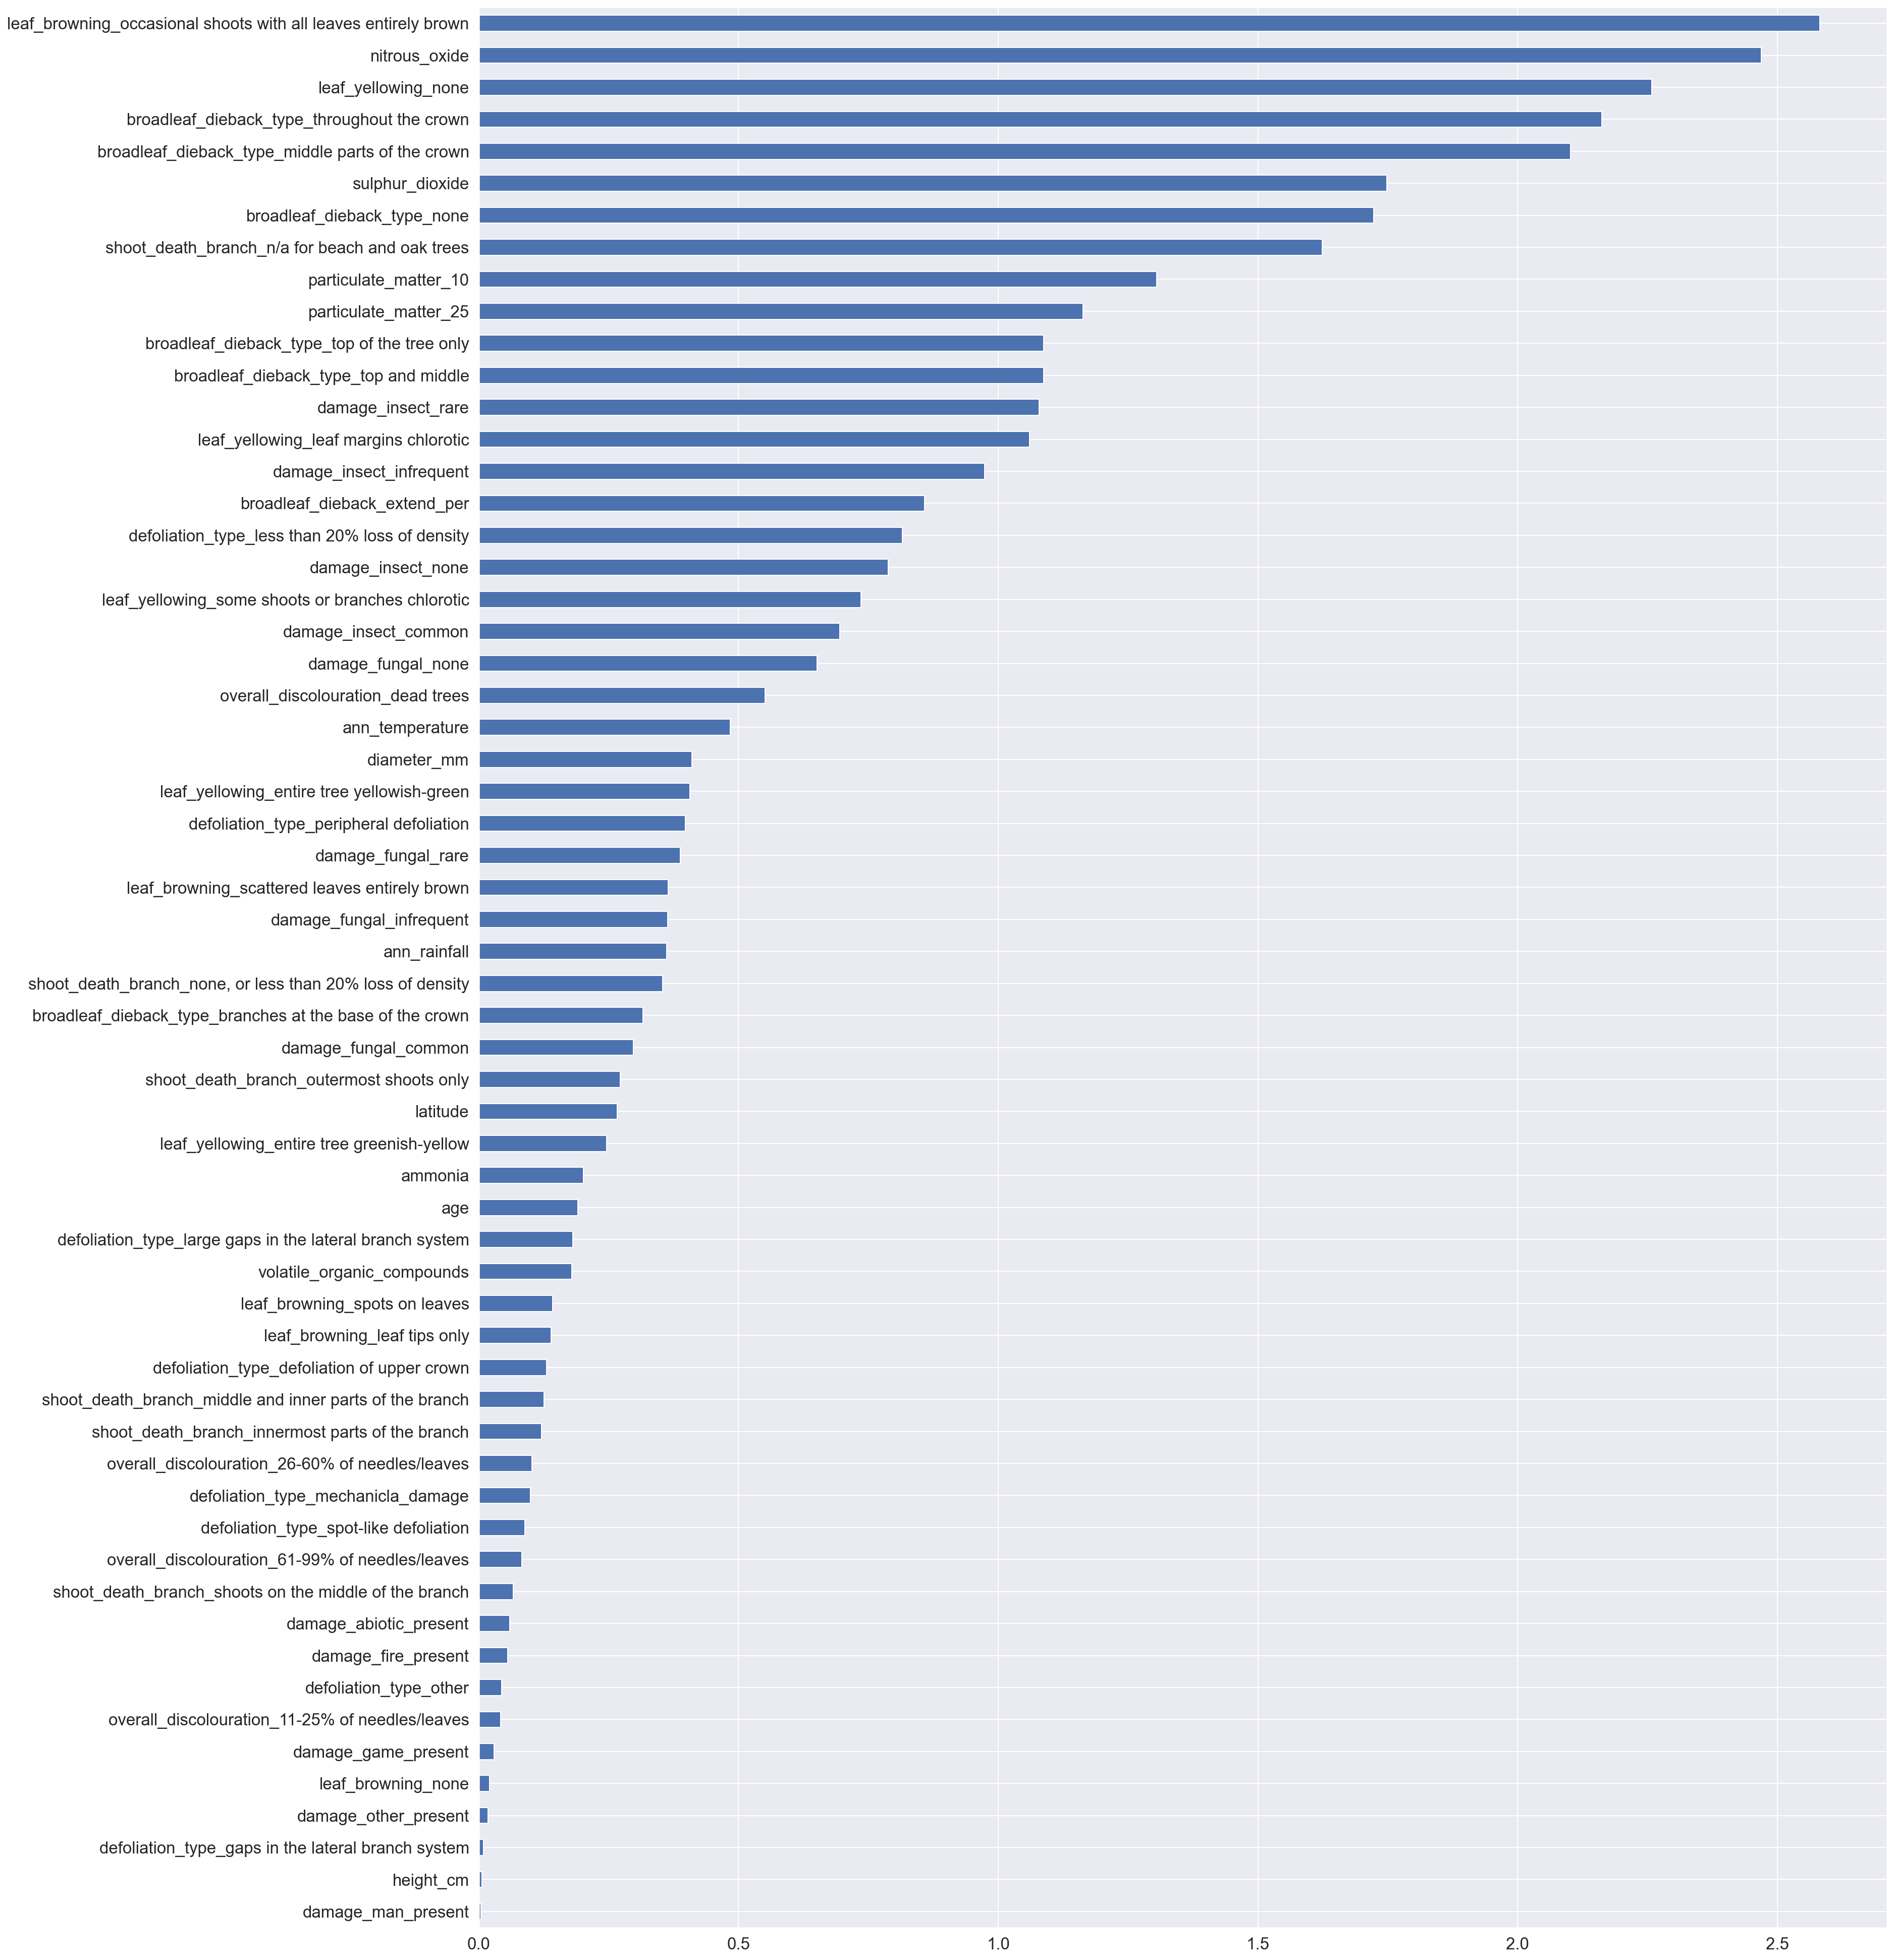

In [45]:
df_coef['coef_abs'].sort_values().plot(kind='barh', figsize=(25, 35));

In [46]:
predictions = best_model.predict(X2_test)
confusion = confusion_matrix(y_test, predictions, labels=[1, 0])
pd.DataFrame(confusion,
             columns=['predicted_tree_deterioration', 'predicted_healthy_tree'],
             index=['True_tree_deterioration', 'True_healthy_tree'])

,predicted_tree_deterioration,predicted_healthy_tree
True_tree_deterioration,2130,1432
True_healthy_tree,1087,4736


The classification matrix resulted in:
* 2130 true positive predictions 
* 4736 true negative predictions 
* 1432 false positive predictions
* 1087 false negative predictions

The matrix is very useful in checking performance of the model. Its features enable to look at important performance measures, that help to justify the model.

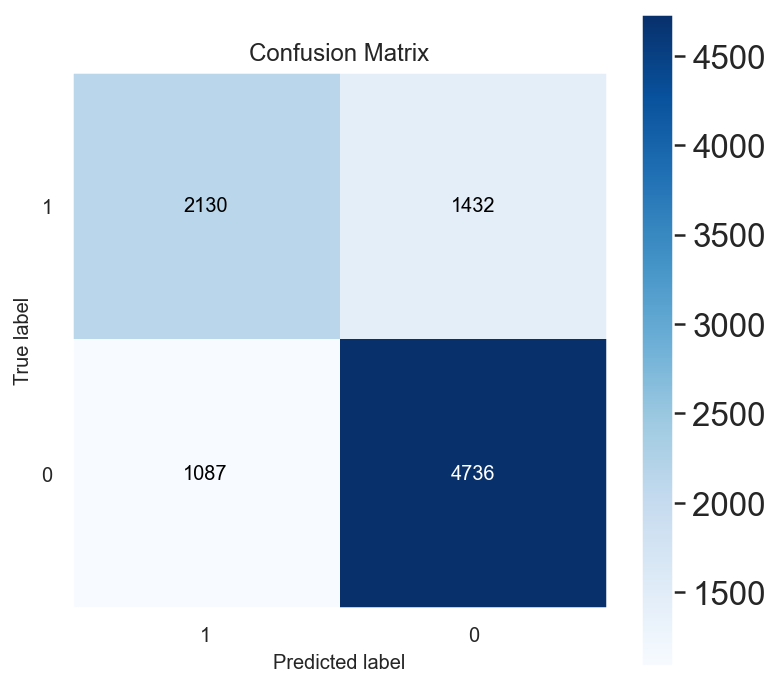

In [47]:
skplt.metrics.plot_confusion_matrix(y_test, predictions, labels=[1, 0], figsize=(6, 6))
plt.show()

In [48]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      5823
           1       0.66      0.60      0.63      3562

    accuracy                           0.73      9385
   macro avg       0.71      0.71      0.71      9385
weighted avg       0.73      0.73      0.73      9385



Precision shows what proportion of positive class were actually positive and in our model its 77 % in class 0 and 66 % in class 1 .

Recall in here is 0.81 for low class - healthy tree and 0.60 for high class - deteriorating tree, meaning 81 % and 60 % of samples were correctly predicted as positive.
In our case meaning 81% of our variables were correctly identified as predictor of healthy trees and 60% of variable samples were correctly identified as predictor of deteriorating trees.

Accuracy shows the fraction of total samples that were correctly classified and in this model its 73%, therefore the missclassification rate is 0.27 - 27%, which explains some of the unecxpected results. For Instance, Level of 60-99% overall discolouration in neddles/trees  were identified by the model as not a strong predictor of tree deterioration.

In [49]:
probabilities_train = best_model.predict_proba(X2_train)
probabilities_test = best_model.predict_proba(X2_test)

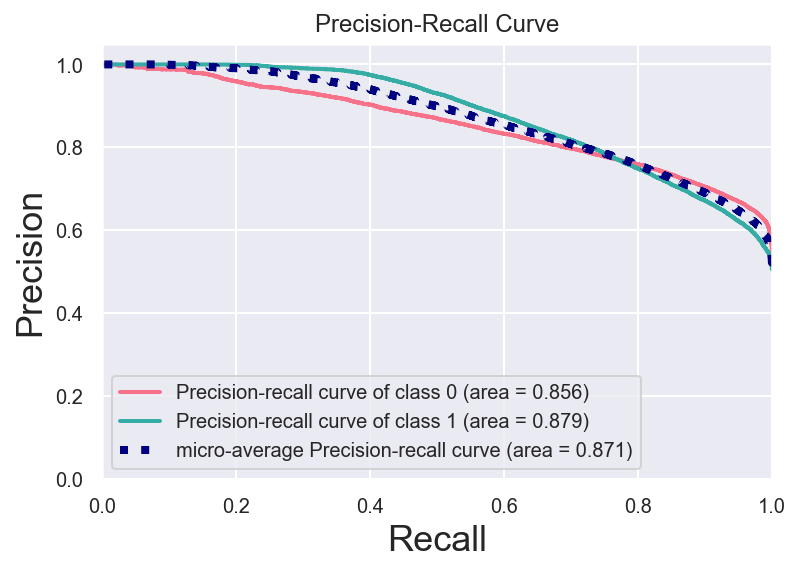

In [50]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", len(best_model.classes_)))
skplt.metrics.plot_precision_recall(y_train, probabilities_train, cmap=cmap)
plt.show()

This Precission recall curve shows the trade off between precission and recall for different threshold. It measures how successfull prediction is when classes are very imbalanced. A high area under the curve represents both high recall and high precission, where high precission indicate a low false positive rate and a high recall indicate low false negative rate. The graph shows very high AUC scores, confirming the model can be trusted in predicting tree condition based on the majority of the predictors chosen for the model.

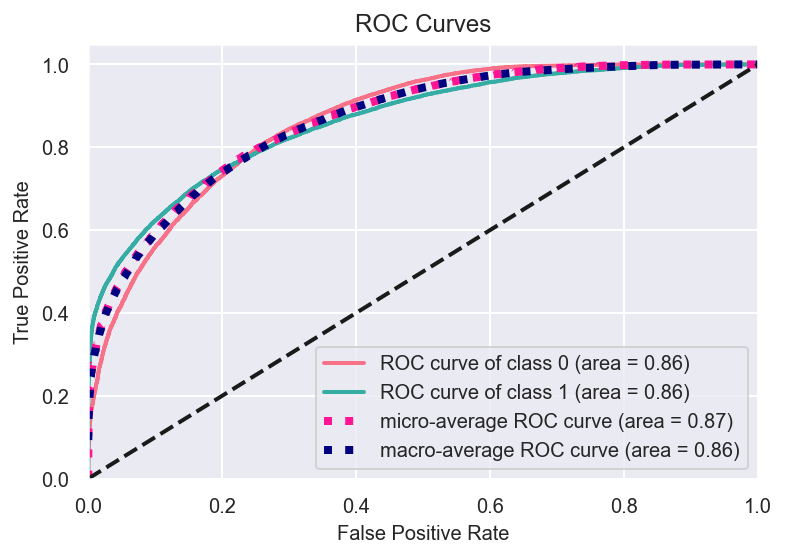

In [51]:
skplt.metrics.plot_roc(y_train, probabilities_train, cmap=cmap)
plt.show()

The receiver operating characteristic curve is another evaluation tool to see the performance of binary classification algorithms. It provides a graphical overal representation of classifier as a whole rather than a single value. 
Similary like with the graph above, the higher area under the curve, higher AUC score the better classifier performs. 
